## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
import re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
nltk_data[:3]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [3]:
# Splitting into train and validation sets
train_set, validation_set = train_test_split(nltk_data,test_size=0.05,random_state = 100)

print(len(train_set))
print(len(validation_set))
print(train_set[:40])

3718
196
[[('One', 'NUM'), ('bright', 'ADJ'), ('sign', 'NOUN'), ('is', 'VERB'), ('that', 'ADP'), ('a', 'DET'), ('growing', 'VERB'), ('number', 'NOUN'), ('of', 'ADP'), ('women', 'NOUN'), ('have', 'VERB'), ('entered', 'VERB'), ('the', 'DET'), ('once', 'ADV'), ('male-dominated', 'ADJ'), ('field', 'NOUN'), (';', '.'), ('more', 'ADJ'), ('than', 'ADP'), ('a', 'DET'), ('third', 'ADJ'), ('of', 'ADP'), ('the', 'DET'), ('ringers', 'NOUN'), ('today', 'NOUN'), ('are', 'VERB'), ('women', 'NOUN'), ('.', '.')], [('``', '.'), ('These', 'DET'), ('days', 'NOUN'), (',', '.'), ('banking', 'NOUN'), ('customers', 'NOUN'), ('walk', 'VERB'), ('in', 'ADP'), ('the', 'DET'), ('door', 'NOUN'), ('*-1', 'X'), ('expecting', 'VERB'), ('you', 'PRON'), ('to', 'PRT'), ('have', 'VERB'), ('a', 'DET'), ('package', 'NOUN'), ('especially', 'ADV'), ('for', 'ADP'), ('them', 'PRON'), (',', '.'), ("''", '.'), ('Ms.', 'NOUN'), ('Moore', 'NOUN'), ('says', 'VERB'), ('*T*-2', 'X'), ('.', '.')], [('The', 'DET'), ('rights', 'NOUN'), (

In [4]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95949

In [5]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['One',
 'bright',
 'sign',
 'is',
 'that',
 'a',
 'growing',
 'number',
 'of',
 'women']

In [6]:
# vocabulary
V = set(tokens)
print(len(V))

12106


In [7]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
print('No. of unique tags are',len(T),'which are as follows:')
print(T)

No. of unique tags are 12 which are as follows:
{'NUM', 'PRON', 'ADJ', 'X', 'ADV', 'ADP', 'VERB', 'PRT', '.', 'CONJ', 'DET', 'NOUN'}


### Emission Probabilities

In [8]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [9]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probabilities

In [10]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [11]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [12]:
tags_matrix

array([[1.84194893e-01, 1.48544263e-03, 3.35710049e-02, 2.11824119e-01,
        2.67379684e-03, 3.50564457e-02, 1.69340465e-02, 2.61437912e-02,
        1.18835412e-01, 1.30718956e-02, 3.86215094e-03, 3.52346987e-01],
       [7.27969361e-03, 7.66283507e-03, 7.20306486e-02, 9.27203074e-02,
        3.40996161e-02, 2.33716480e-02, 4.84291196e-01, 1.22605367e-02,
        4.06130254e-02, 4.98084305e-03, 9.19540226e-03, 2.11494252e-01],
       [2.08026208e-02, 4.91400482e-04, 6.71580657e-02, 2.03112196e-02,
        4.91400482e-03, 7.86240771e-02, 1.17936116e-02, 1.01556098e-02,
        6.38820603e-02, 1.60524156e-02, 4.91400482e-03, 7.00900912e-01],
       [2.85668951e-03, 5.57054430e-02, 1.65053159e-02, 7.44326264e-02,
        2.53927950e-02, 1.44897640e-01, 2.04570696e-01, 1.84891284e-01,
        1.62831292e-01, 1.03158224e-02, 5.52293286e-02, 6.23710528e-02],
       [3.16244997e-02, 1.56458057e-02, 1.30159780e-01, 2.33022645e-02,
        7.72303566e-02, 1.19507320e-01, 3.44540626e-01, 1.43

In [13]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [14]:
tags_df

,NUM,PRON,ADJ,X,ADV,ADP,VERB,PRT,.,CONJ,DET,NOUN
NUM,0.184195,0.001485,0.033571,0.211824,0.002674,0.035056,0.016934,0.026144,0.118835,0.013072,0.003862,0.352347
PRON,0.007280,0.007663,0.072031,0.092720,0.034100,0.023372,0.484291,0.012261,0.040613,0.004981,0.009195,0.211494
ADJ,0.020803,0.000491,0.067158,0.020311,0.004914,0.078624,0.011794,0.010156,0.063882,0.016052,0.004914,0.700901
X,0.002857,0.055705,0.016505,0.074433,0.025393,0.144898,0.204571,0.184891,0.162831,0.010316,0.055229,0.062371
ADV,0.031624,0.015646,0.130160,0.023302,0.077230,0.119507,0.344541,0.014314,0.135153,0.006991,0.069907,0.031624
ADP,0.061910,0.069119,0.107389,0.034984,0.013357,0.017492,0.008481,0.001484,0.039754,0.000848,0.323969,0.321213
VERB,0.022448,0.035916,0.065640,0.218438,0.082050,0.091184,0.168744,0.031427,0.034291,0.005186,0.133292,0.111386
PRT,0.056102,0.017717,0.083661,0.013123,0.010171,0.019357,0.405184,0.001969,0.043635,0.002297,0.101050,0.245735
.,0.081353,0.065208,0.043681,0.026908,0.052292,0.092206,0.088708,0.002511,0.092923,0.058032,0.173558,0.222531
CONJ,0.042188,0.058414,0.118683,0.008809,0.053778,0.053778,0.155308,0.003709,0.035698,0.000464,0.118683,0.350487


In [15]:
tags_df.loc['.', :]

NUM     0.081353
PRON    0.065208
ADJ     0.043681
X       0.026908
ADV     0.052292
ADP     0.092206
VERB    0.088708
PRT     0.002511
.       0.092923
CONJ    0.058032
DET     0.173558
NOUN    0.222531
Name: ., dtype: float32

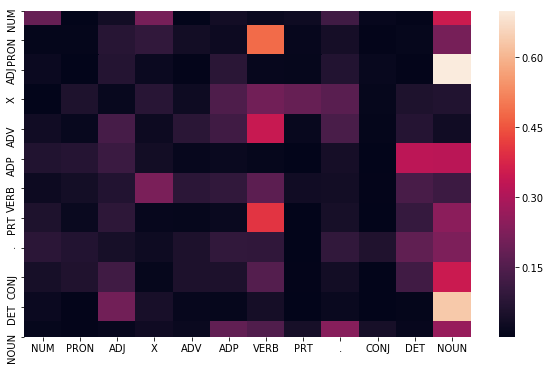

In [16]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(10, 6))
sns.heatmap(tags_df)
plt.show()


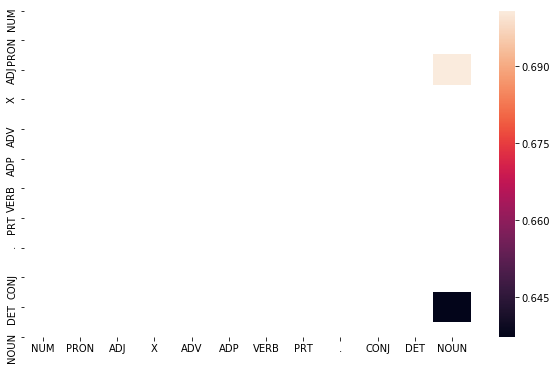

In [17]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(10, 6))
sns.heatmap(tags_frequent)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [18]:
# Vanilla Viterbi Heuristic
def vanilla_Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


In [19]:
# Running on entire test dataset would take more than 30 mins. 
# Let's test our Viterbi algorithm on a few sample sentences of validation dataset

random.seed(1234)

# choose random 10 sents
rndom = [random.randint(1,len(validation_set)) for x in range(10)]

# list of sents
validation_run = [validation_set[i] for i in rndom]

# list of tagged words
validation_run_base = [tup for sent in validation_run for tup in sent]

# list of untagged words
validation_tagged_words = [tup[0] for sent in validation_run for tup in sent]
validation_run

[[('Hearst', 'NOUN'),
  ('had', 'VERB'),
  ('flirted', 'VERB'),
  ('with', 'ADP'),
  ('a', 'DET'),
  ('conversion', 'NOUN'),
  ('to', 'PRT'),
  ('tabloid', 'ADJ'),
  ('format', 'NOUN'),
  ('for', 'ADP'),
  ('years', 'NOUN'),
  ('but', 'CONJ'),
  ('never', 'ADV'),
  ('executed', 'VERB'),
  ('the', 'DET'),
  ('plan', 'NOUN'),
  ('.', '.')],
 [('``', '.'),
  ('The', 'DET'),
  ('record', 'NOUN'),
  ('of', 'ADP'),
  ('companies', 'NOUN'),
  ('that', 'DET'),
  ('*T*-8', 'X'),
  ('have', 'VERB'),
  ('diversified', 'VERB'),
  ('is', 'VERB'),
  ("n't", 'ADV'),
  ('all', 'DET'),
  ('that', 'DET'),
  ('impressive', 'ADJ'),
  (',', '.'),
  ("''", '.'),
  ('he', 'PRON'),
  ('says', 'VERB'),
  ('*T*-1', 'X'),
  ('.', '.')],
 [('An', 'DET'),
  ('official', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('Palestinian', 'NOUN'),
  ('Olympic', 'NOUN'),
  ('Committee', 'NOUN'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('the', 'DET'),
  ('committee', 'NOUN'),
  ('first', 'ADV'),
  ('applied', 'VERB'),
  ('for',

In [20]:
# Tagging the validation sentences using vanilla Viterbi algorithm
start = time.time()
tagged_seq = vanilla_Viterbi(validation_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)

# Accuracy
check = [i for i, j in zip(tagged_seq, validation_run_base) if i == j] 
vanilla_viterbi_accuracy = round((len(check)/len(tagged_seq))*100,2)
print('\nAccuracy of vanilla Viterbi is ',vanilla_viterbi_accuracy,'%')

Time taken in seconds:  156.5071496963501
[('Hearst', 'NOUN'), ('had', 'VERB'), ('flirted', 'NUM'), ('with', 'ADP'), ('a', 'DET'), ('conversion', 'NOUN'), ('to', 'PRT'), ('tabloid', 'ADJ'), ('format', 'NOUN'), ('for', 'ADP'), ('years', 'NOUN'), ('but', 'CONJ'), ('never', 'ADV'), ('executed', 'VERB'), ('the', 'DET'), ('plan', 'NOUN'), ('.', '.'), ('``', '.'), ('The', 'DET'), ('record', 'NOUN'), ('of', 'ADP'), ('companies', 'NOUN'), ('that', 'ADP'), ('*T*-8', 'X'), ('have', 'VERB'), ('diversified', 'ADJ'), ('is', 'VERB'), ("n't", 'ADV'), ('all', 'DET'), ('that', 'ADP'), ('impressive', 'NUM'), (',', '.'), ("''", '.'), ('he', 'PRON'), ('says', 'VERB'), ('*T*-1', 'X'), ('.', '.'), ('An', 'DET'), ('official', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('Palestinian', 'ADJ'), ('Olympic', 'NOUN'), ('Committee', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('the', 'DET'), ('committee', 'NOUN'), ('first', 'ADJ'), ('applied', 'VERB'), ('for', 'ADP'), ('membership', 'NOUN'), ('in', 'ADP'), ('1979', 'NUM'),

In [21]:
# Checking incorrect tagged cases
incorrect_tagged_cases = [[validation_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, validation_run_base)) 
                          if j[0]!=j[1]]
incorrect_tagged_cases

[[('had', 'VERB'), (('flirted', 'NUM'), ('flirted', 'VERB'))],
 [('companies', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('have', 'VERB'), (('diversified', 'ADJ'), ('diversified', 'VERB'))],
 [('all', 'DET'), (('that', 'ADP'), ('that', 'DET'))],
 [('that', 'DET'), (('impressive', 'NUM'), ('impressive', 'ADJ'))],
 [('the', 'DET'), (('Palestinian', 'ADJ'), ('Palestinian', 'NOUN'))],
 [('committee', 'NOUN'), (('first', 'ADJ'), ('first', 'ADV'))],
 [('stocks', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('that', 'DET'), (('*T*-117', 'NUM'), ('*T*-117', 'X'))],
 [('to', 'PRT'), (('uptick', 'NOUN'), ('uptick', 'VERB'))],
 [(',', '.'), (('head', 'NOUN'), ('head', 'ADJ'))],
 [('Donald', 'NOUN'), (('Anderson', 'NUM'), ('Anderson', 'NOUN'))],
 [('a', 'DET'), (('59-year-old', 'NUM'), ('59-year-old', 'ADJ'))],
 [('``', '.'), (('fluctuations', 'NUM'), ('fluctuations', 'NOUN'))],
 [('the', 'DET'), (('heebie-jeebies', 'NUM'), ('heebie-jeebies', 'NOUN'))],
 [('see', 'VERB'), (('much', 'ADV')

### Solve the problem of unknown words

#### <font color='red'>1. Modifying Viterbi algorithm so that all unknown words take most frequent tag 

In [22]:
# Finding most frequent tag
from collections import Counter
tags = [pair[1] for pair in train_tagged_words]
tag_counts = Counter(tags)
# Checking 5 most common tags
tag_counts.most_common(5)

[('NOUN', 27539), ('VERB', 12919), ('.', 11149), ('ADP', 9433), ('DET', 8318)]

In [23]:
from nltk.tag import DefaultTagger 
  
# Defining most frequent tag 
tagging = DefaultTagger('NOUN') 

In [24]:
# 1st modified Viterbi Heuristic
def Viterbi_mod_1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p 
            p.append(state_probability)
        pmax = max(p)
        state_max = tagging.tag([word])[0][1]
        
        if pmax==0:
            state_max = tagging.tag([word])[0][1] # Tagging 'NOUN'(most frequent tag) to unknown words
        else:
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#### <font color='red'>2. Modifying Viterbi algorithm using combination of rule based and unigram tagger.

In [25]:
# To improve the performance,we specify combination of rule based and unigram tagger for unknown words 
# Creating patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*(s|\'s)$', 'NOUN'),          # plural and possessive nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'.*ive$', 'ADJ'),               # ADJ  for words such aggressive, secretive
    (r'.*', 'NOUN'),                  # for words not satisfying above rules 
]

# rule based tagger
rbt = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rbt)

In [26]:
# 2nd modified Viterbi technique using combination of rule based and unigram tagger.
def Viterbi_mod_2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        state_max = lexicon_tagger.tag([word])[0][1]       
       
        if(pmax==0):
            state_max = lexicon_tagger.tag([word])[0][1] # using combination of rule based and unigram tagger for unknown words.
        else:
            if state_max != 'X':
                state_max = T[p.index(pmax)]                        
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

#### <font color='red'>Tagging the validation sentences using 1st modified Viterbi algorithm

In [27]:
start = time.time()
tagged_seq_1 = Viterbi_mod_1(validation_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq_1)

# Accuracy
check = [i for i, j in zip(tagged_seq_1, validation_run_base) if i == j] 
viterbi_mod_1_accuracy = round((len(check)/len(tagged_seq_1))*100,2)
print('\nAccuracy of Viterbi_mod_1 is ',viterbi_mod_1_accuracy,'%')

Time taken in seconds:  157.59405159950256
[('Hearst', 'NOUN'), ('had', 'VERB'), ('flirted', 'NOUN'), ('with', 'ADP'), ('a', 'DET'), ('conversion', 'NOUN'), ('to', 'PRT'), ('tabloid', 'ADJ'), ('format', 'NOUN'), ('for', 'ADP'), ('years', 'NOUN'), ('but', 'CONJ'), ('never', 'ADV'), ('executed', 'VERB'), ('the', 'DET'), ('plan', 'NOUN'), ('.', '.'), ('``', '.'), ('The', 'DET'), ('record', 'NOUN'), ('of', 'ADP'), ('companies', 'NOUN'), ('that', 'ADP'), ('*T*-8', 'X'), ('have', 'VERB'), ('diversified', 'ADJ'), ('is', 'VERB'), ("n't", 'ADV'), ('all', 'DET'), ('that', 'ADP'), ('impressive', 'NOUN'), (',', '.'), ("''", '.'), ('he', 'PRON'), ('says', 'VERB'), ('*T*-1', 'X'), ('.', '.'), ('An', 'DET'), ('official', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('Palestinian', 'ADJ'), ('Olympic', 'NOUN'), ('Committee', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('the', 'DET'), ('committee', 'NOUN'), ('first', 'ADJ'), ('applied', 'VERB'), ('for', 'ADP'), ('membership', 'NOUN'), ('in', 'ADP'), ('1979', 'NUM

In [28]:
incorrect_tagged_cases = [[validation_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_1, validation_run_base)) 
                          if j[0]!=j[1]]
incorrect_tagged_cases

[[('had', 'VERB'), (('flirted', 'NOUN'), ('flirted', 'VERB'))],
 [('companies', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('have', 'VERB'), (('diversified', 'ADJ'), ('diversified', 'VERB'))],
 [('all', 'DET'), (('that', 'ADP'), ('that', 'DET'))],
 [('that', 'DET'), (('impressive', 'NOUN'), ('impressive', 'ADJ'))],
 [('the', 'DET'), (('Palestinian', 'ADJ'), ('Palestinian', 'NOUN'))],
 [('committee', 'NOUN'), (('first', 'ADJ'), ('first', 'ADV'))],
 [('stocks', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('that', 'DET'), (('*T*-117', 'NOUN'), ('*T*-117', 'X'))],
 [('to', 'PRT'), (('uptick', 'NOUN'), ('uptick', 'VERB'))],
 [(',', '.'), (('head', 'NOUN'), ('head', 'ADJ'))],
 [('a', 'DET'), (('59-year-old', 'NOUN'), ('59-year-old', 'ADJ'))],
 [('see', 'VERB'), (('much', 'ADV'), ('much', 'ADJ'))],
 [('much', 'ADJ'), (('point', 'VERB'), ('point', 'NOUN'))],
 [('*', 'X'), (('outlawing', 'NOUN'), ('outlawing', 'VERB'))],
 [('a', 'DET'), (('following', 'VERB'), ('following', 'NOUN'))]]

#### <font color='red'>Tagging the validation sentences using 2nd modified Viterbi algorithm

In [29]:
start = time.time()
tagged_seq_2 = Viterbi_mod_2(validation_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq_2)
#print(test_run_base)

# Accuracy
check = [i for i, j in zip(tagged_seq_2, validation_run_base) if i == j] 
viterbi_mod_2_accuracy = round((len(check)/len(tagged_seq_2))*100,2)
print('\nAccuracy of Viterbi_mod_2 is ',viterbi_mod_2_accuracy,'%')

Time taken in seconds:  152.00543451309204
[('Hearst', 'NOUN'), ('had', 'VERB'), ('flirted', 'VERB'), ('with', 'ADP'), ('a', 'DET'), ('conversion', 'NOUN'), ('to', 'PRT'), ('tabloid', 'ADJ'), ('format', 'NOUN'), ('for', 'ADP'), ('years', 'NOUN'), ('but', 'CONJ'), ('never', 'ADV'), ('executed', 'VERB'), ('the', 'DET'), ('plan', 'NOUN'), ('.', '.'), ('``', '.'), ('The', 'DET'), ('record', 'NOUN'), ('of', 'ADP'), ('companies', 'NOUN'), ('that', 'ADP'), ('*T*-8', 'X'), ('have', 'VERB'), ('diversified', 'ADJ'), ('is', 'VERB'), ("n't", 'ADV'), ('all', 'DET'), ('that', 'ADP'), ('impressive', 'ADJ'), (',', '.'), ("''", '.'), ('he', 'PRON'), ('says', 'VERB'), ('*T*-1', 'X'), ('.', '.'), ('An', 'DET'), ('official', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('Palestinian', 'ADJ'), ('Olympic', 'NOUN'), ('Committee', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('the', 'DET'), ('committee', 'NOUN'), ('first', 'ADJ'), ('applied', 'VERB'), ('for', 'ADP'), ('membership', 'NOUN'), ('in', 'ADP'), ('1979', 'NUM'

In [30]:
incorrect_tagged_cases = [[validation_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_2, validation_run_base)) 
                          if j[0]!=j[1]]
incorrect_tagged_cases

[[('companies', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('have', 'VERB'), (('diversified', 'ADJ'), ('diversified', 'VERB'))],
 [('all', 'DET'), (('that', 'ADP'), ('that', 'DET'))],
 [('the', 'DET'), (('Palestinian', 'ADJ'), ('Palestinian', 'NOUN'))],
 [('committee', 'NOUN'), (('first', 'ADJ'), ('first', 'ADV'))],
 [('stocks', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('to', 'PRT'), (('uptick', 'NOUN'), ('uptick', 'VERB'))],
 [(',', '.'), (('head', 'NOUN'), ('head', 'ADJ'))],
 [('a', 'DET'), (('59-year-old', 'NOUN'), ('59-year-old', 'ADJ'))],
 [('the', 'DET'), (('heebie-jeebies', 'VERB'), ('heebie-jeebies', 'NOUN'))],
 [('see', 'VERB'), (('much', 'ADV'), ('much', 'ADJ'))],
 [('much', 'ADJ'), (('point', 'VERB'), ('point', 'NOUN'))],
 [('a', 'DET'), (('following', 'VERB'), ('following', 'NOUN'))]]

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [31]:
# Creating dataframe for comparing accuracies of different approaches of viterbi algorithm
acc_dict = {'Technique name': ['Vanilla Viterbi','Viterbi_mod_1','Viterbi_mod_2'],
             'Accuracy':[vanilla_viterbi_accuracy, viterbi_mod_1_accuracy, viterbi_mod_2_accuracy]}
acc_df = pd.DataFrame(acc_dict)
acc_df.head()

,Technique name,Accuracy
0,Vanilla Viterbi,92.42
1,Viterbi_mod_1,94.22
2,Viterbi_mod_2,95.31


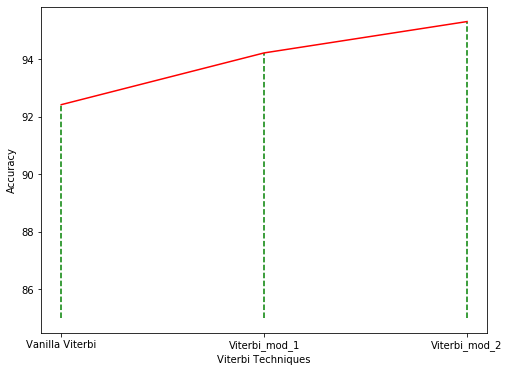

In [32]:
# Creating visual representation accuracy of different viterbi approaches
fig = plt.figure(figsize=[8,6])

plt.plot(acc_df['Technique name'], acc_df['Accuracy'], color ='red')
plt.vlines(x='Vanilla Viterbi', ymax = vanilla_viterbi_accuracy, ymin=85, colors="g", linestyles="--")
plt.vlines(x='Viterbi_mod_1', ymax = viterbi_mod_1_accuracy, ymin=85, colors="g", linestyles="--")
plt.vlines(x='Viterbi_mod_2', ymax = viterbi_mod_2_accuracy, ymin=85, colors="g", linestyles="--")
plt.xlabel("Viterbi Techniques")
plt.ylabel("Accuracy")

plt.show()

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [33]:
# Reading test sentences file
test_sentences = open('Test_sentences.txt',mode='r')
text_file_read = test_sentences.read() 
sample_sentences = text_file_read.splitlines()
test_sentences.close()
sample_sentences

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [34]:
# Creating function for tagging comparison between vanilla Viterbi and modified Viterbi technique
def compare_tagging(sample_sentence):
    tagging_1 = vanilla_Viterbi(word_tokenize(sample_sentence))
    tagging_2 = Viterbi_mod_2(word_tokenize(sample_sentence))
        
    word =[]
    Vanilla_Viterbi_tag = []
    Viterbi_mod_2_tag = []
    
    for i,j in tagging_1: 
        for x,y in tagging_2:
            if(i==x and j!=y):
                word.append(i)
                Vanilla_Viterbi_tag.append(j)                
                Viterbi_mod_2_tag.append(y)

    tagging_dict = {'Word':word, 'Vanilla_Viterbi_tag':Vanilla_Viterbi_tag, 'Viterbi_mod_2_tag':Viterbi_mod_2_tag}
    tagging_df = pd.DataFrame(tagging_dict)  # Creating dataframe
    print('Sentence: ',sample_sentence)
    print('-'*120)
    return(tagging_df.head(30))

#### <font color = 'red'>Tagging sample sentences using vanilla Viterbi and modified Viterbi techniques 

In [35]:
# Sample test case 1:
compare_tagging(sample_sentences[0])

Sentence:  Android is a mobile operating system developed by Google.
------------------------------------------------------------------------------------------------------------------------


,Word,Vanilla_Viterbi_tag,Viterbi_mod_2_tag
0,Android,NUM,NOUN
1,Google,NUM,NOUN


#### <font color = 'red'>As you can see the words `'Android'` and `'Google'` which were incorrectly tagged by Vanilla Viterbi are tagged correctly as `'NOUN'` by modified Viterbi method using combination of rule based and unigram tagger.

In [36]:
# Sample test case 2:
compare_tagging(sample_sentences[1])

Sentence:  Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
------------------------------------------------------------------------------------------------------------------------


,Word,Vanilla_Viterbi_tag,Viterbi_mod_2_tag
0,Android,NUM,NOUN
1,OS,NUM,NOUN
2,worldwide,NUM,NOUN
3,smartphones,NUM,VERB


#### <font color = 'red'>Here the words `'Android'` and `'OS'` which were incorrectly tagged by Vanilla Viterbi are tagged correctly as `'NOUN'` by modified Viterbi method using combination of rule based and unigram tagger.

In [37]:
# Sample test case 3:
compare_tagging(sample_sentences[2])

Sentence:  Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.
------------------------------------------------------------------------------------------------------------------------


,Word,Vanilla_Viterbi_tag,Viterbi_mod_2_tag
0,Google,NUM,NOUN
1,Google,NUM,NOUN
2,Twitter,NUM,NOUN
3,Twitter,NUM,NOUN
4,Google,NUM,NOUN
5,Google,NUM,NOUN
6,Twitter,NUM,NOUN
7,Twitter,NUM,NOUN
8,firehose,NUM,NOUN


#### <font color = 'red'>Here the words `'Google'`, `'Twitter'` and `'firehose'` which were incorrectly tagged by Vanilla Viterbi are tagged correctly as `'NOUN'` by modified Viterbi method using combination of rule based and unigram tagger.

In [38]:
# Sample test case 4:
compare_tagging(sample_sentences[3])

Sentence:  Twitter is an online news and social networking service on which users post and interact with messages known as tweets.
------------------------------------------------------------------------------------------------------------------------


,Word,Vanilla_Viterbi_tag,Viterbi_mod_2_tag
0,Twitter,NUM,NOUN
1,online,NUM,NOUN
2,interact,NUM,NOUN
3,messages,NUM,VERB
4,tweets,NUM,NOUN


#### <font color = 'red'>Here the words `'Twitter'` and `'tweets'` which were incorrectly tagged by Vanilla Viterbi are tagged correctly as `'NOUN'` by modified Viterbi method using combination of rule based and unigram tagger.

In [39]:
# Sample test case 5:
compare_tagging(sample_sentences[4])

Sentence:  Before entering politics, Donald Trump was a domineering businessman and a television personality.
------------------------------------------------------------------------------------------------------------------------


,Word,Vanilla_Viterbi_tag,Viterbi_mod_2_tag
0,domineering,NUM,VERB
1,personality,NUM,NOUN


#### <font color = 'red'>Here the word `'personality'`  which was incorrectly tagged by Vanilla Viterbi is tagged correctly as `'NOUN'` by modified Viterbi method using combination of rule based and unigram tagger.

In [40]:
# Sample test case 6:
compare_tagging(sample_sentences[5])

Sentence:  The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.
------------------------------------------------------------------------------------------------------------------------


,Word,Vanilla_Viterbi_tag,Viterbi_mod_2_tag
0,FIFA,NUM,NOUN
1,FIFA,NUM,NOUN
2,Cup,NUM,NOUN
3,Cup,NUM,NOUN
4,21st,NUM,NOUN
5,FIFA,NUM,NOUN
6,FIFA,NUM,NOUN
7,Cup,NUM,NOUN
8,Cup,NUM,NOUN
9,tournament,NUM,NOUN


#### <font color = 'red'>Here the words `'FIFA'`, `'Cup'` and `'tournament'` which were incorrectly tagged by Vanilla Viterbi are tagged correctly as `'NOUN'`
#### <font color = 'red'>and `'contested'` is correctly tagged as `'VERB'` by modified Viterbi method using combination of rule based and unigram tagger.

### <font color = 'blue'>Conclusion:
### <font color = 'blue'>Thus we conclude that the modified Viterbi algorithm using combination of rule based and unigram tagger works well in case of unknown words as compared to the vanilla Viterbi algorithm.